<div class="jumbotron text-left"><b>
This tutorial describes how to use the SMT toolbox with multifidelity data to build a surrogate model that uses the sparse Gaussian processes
approximation in all the fidelity-levels</b></div>

Mauricio CASTANO AGUIRRE ONERA/DTIS/M2CI - PhD.student

April 2025

In [1]:
!pip install smt

### Sparse Multi-Fidelity Co-Kriging (SMFCK)

In the multi-fidelity Gaussian Process (GP) framework, the computational complexity scales cubically with the total number of observations 
$$ 
N = \sum_{\kappa=0}^{L} N_\kappa. 
$$ 
To address this limitation, we consider a sparse approximation.

#### Inducing Variables for Multi-Fidelity Models

To construct a sparse approximation, we introduce inducing variables at each fidelity level. Let 
$$ 
\mathbf{Z}_\kappa = (\mathbf{z}_{\kappa, i})_{1 \leq i \leq M_\kappa} 
$$ 
be the set of inducing points for the $\kappa$-th fidelity, where 
$$ 
M_\kappa \ll N_\kappa. 
$$ 
We define the inducing variables as:

$$
\mathbf{u}_\kappa = y_\kappa(\mathbf{Z}_\kappa), \quad \forall \kappa \in \{0, \ldots, L\}.
$$

Since $y_\kappa$ is GP distributed and $\mathbf{u}_\kappa$ consists of its evaluations at inducing points, it follows that $\mathbf{u}_\kappa$ is Gaussian distributed. Recall that $\mathbf{y} = [ \mathbf{y}_0, \cdots, \mathbf{y}_L ]^\top$
and denote $\mathbf{u} = [ \mathbf{u}_0, \cdots, \mathbf{u}_L ]^\top.$  The joint distribution of the function values and the inducing variables is given by:
$$
\begin{bmatrix}
    \mathbf{y} \\
    \mathbf{u}
\end{bmatrix} 
\sim \mathcal{N} \left(
\mathbf{0},
\begin{bmatrix}
    \mathbf{K}_{\mathbf{y},\mathbf{y}} & \mathbf{K}_{\mathbf{y},\mathbf{u}} \\
    \mathbf{K}_{\mathbf{u},\mathbf{y}} & \mathbf{K}_{\mathbf{u},\mathbf{u}}
\end{bmatrix} \right),
$$

where 
$$ 
(\mathbf{K}_{\mathbf{y},\mathbf{y}})_{\kappa,\kappa'} = k_{\kappa,\kappa^\prime}(\mathbf{X}_\kappa,\mathbf{X}_{\kappa^\prime}), \quad
(\mathbf{K}_{\mathbf{y},\mathbf{u}})_{\kappa,\kappa^\prime} = k_{\kappa,\kappa^\prime}(\mathbf{X}_\kappa,\mathbf{Z}_{\kappa^\prime}), \quad
(\mathbf{K}_{\mathbf{u},\mathbf{u}})_{\kappa,\kappa^\prime} = k_{\kappa,\kappa^\prime}(\mathbf{Z}_\kappa,\mathbf{Z}_{\kappa^\prime}) 
$$ 
are block-wise covariance matrices with a kernel $k_{\kappa,\kappa'}.$

#### Fully Independent Training Conditional (FITC) Approximation

In the FITC approach, we approximate the conditional prior 
$$ 
p(\mathbf{y} | \mathbf{u}) 
$$ 
by assuming independence given the inducing points:

$$
p(\mathbf{y} | \mathbf{u}) \approx \mathcal{N} (\mathbf{K}_{\mathbf{y},\mathbf{u}} \mathbf{K}_{\mathbf{u},\mathbf{u}}^{-1} \mathbf{u}, \mathbf{K}_{\mathbf{y},\mathbf{y}} - \mathbf{K}_{\mathbf{y},\mathbf{u}} \mathbf{K}_{\mathbf{u},\mathbf{u}}^{-1} \mathbf{K}_{\mathbf{u},\mathbf{y}}).
$$

The inducing variables $\mathbf{Z}_\kappa$ are typically chosen as a subset of the training inputs $\mathbf{X}_\kappa.$ We then construct a matrix $\bm{\mathcal{Q}}$ to approximate the true covariance $\mathbf{K}$ 
using the Nyström method. The approximation becomes:

$$
\bm{\mathcal{Q}} = \mathbf{K}_{\mathbf{y},\mathbf{u}} \mathbf{K}_{\mathbf{u},\mathbf{u}}^{-1} \mathbf{K}_{\mathbf{u},\mathbf{y}}.
$$

We define 
$$ 
\mathbf{K}_{\mathbf{X}_\kappa,\mathbf{Z}_{\kappa'}} = k_{\kappa,\kappa'}(\mathbf{X}_\kappa,\mathbf{Z}_{\kappa'}) 
$$ 
and 
$$ 
\mathbf{K}_{\mathbf{Z}_\kappa,\mathbf{Z}_{\kappa'}} = k_{\kappa,\kappa'}(\mathbf{Z}_\kappa,\mathbf{Z}_{\kappa'}). 
$$ 
The full-rank Nyström approximation used in FITC is:

$$
\bm{\mathcal{Q}} =
\begin{bmatrix}
    \mathbf{K}_{X_0 Z_0} & \cdots & \mathbf{K}_{X_0 Z_L} \\
    \vdots & \ddots & \vdots \\
    \mathbf{K}_{X_L Z_0} & \cdots & \mathbf{K}_{X_L Z_L}
\end{bmatrix}
\begin{bmatrix}
    \mathbf{K}_{Z_0 Z_0} & \cdots & \mathbf{K}_{Z_0 Z_L} \\
    \vdots & \ddots & \vdots \\
    \mathbf{K}_{Z_L Z_0} & \cdots & \mathbf{K}_{Z_L Z_L}
\end{bmatrix}^{-1}
\begin{bmatrix}
    \mathbf{K}_{Z_0 X_0} & \cdots & \mathbf{K}_{Z_0 X_L} \\
    \vdots & \ddots & \vdots \\
    \mathbf{K}_{Z_L X_0} & \cdots & \mathbf{K}_{Z_L X_L}
\end{bmatrix}.
$$

The exact covariance is replaced by the Nyström approximation. The FITC method corrects this approximation by using the exact diagonal elements of the original covariance matrix:

$$
\widetilde{\bm{\mathcal{Q}}} = \bm{\mathcal{Q}} + \text{diag}\left[\mathbf{K} - \bm{\mathcal{Q}}\right].
$$

We then establish the joint distribution of 
$$ 
(\mathbf{y}_0, \cdots, \mathbf{y}_L) 
$$ 
using the corrected Nyström approximation:

$$
p(\mathbf{y}) \sim \mathcal{N}(0, \widetilde{\bm{\mathcal{Q}}}).
$$

This leads to the negative marginal log likelihood that we aim to minimize:

$$
\mathcal{L}(\bm{\theta}) = \frac{1}{2}\log\left(\text{det}\left(\widetilde{\bm{\mathcal{Q}}}_{\bm{\theta}} + \mathbf{D}_\theta\right)\right) + \frac{1}{2}\mathbf{y}^\top\left(\widetilde{\bm{\mathcal{Q}}}_{\bm{\theta}} + \mathbf{D}_\theta\right)^{-1}\mathbf{y} + \frac{N}{2}\log(2\pi).
$$

We observe that $\mathcal{L}(\bm{\theta})$ now depends on the inversion of $\widetilde{\mathbf{Q}}_{NN}$
instead of $\mathbf{K}_{NN},$ which can be computed more efficiently using the Woodbury matrix identity (Williams & Rasmussen, 2006; Wilkinson, 2019). The FITC method reduces computational complexity to $\mathcal{O}(NM^2).$ However, since we modified the GP prior without explicitly minimizing a distance to the original model, the resulting objective may not accurately reflect the true GP model.

**References:**

- Williams, C. K. I., & Rasmussen, C. E. (2006). *Gaussian Processes for Machine Learning*. MIT Press.  
- Wilkinson, D. J. (2019). *Stochastic Modelling for Systems Biology* (3rd ed.). CRC Press.

In [2]:
from smt.applications.smfck import SMFCK
import numpy as np
from matplotlib import pyplot as plt
from smt.applications import NestedLHS

import time

%matplotlib inline

In [3]:
# defining low and high fidelity functions

# Define the Forrester function at different fidelity levels
def forrester_low(x):
    return 0.5 * forrester_high(x) + 10 * (x - 0.5) - 5


def forrester_mid(x):
    return 0.8 * forrester_high(x) + 5 * (x - 0.5)


def forrester_high(x):
    return (6 * x - 2) ** 2 * np.sin(12 * x - 4)

Text(0, 0.5, '$y$')

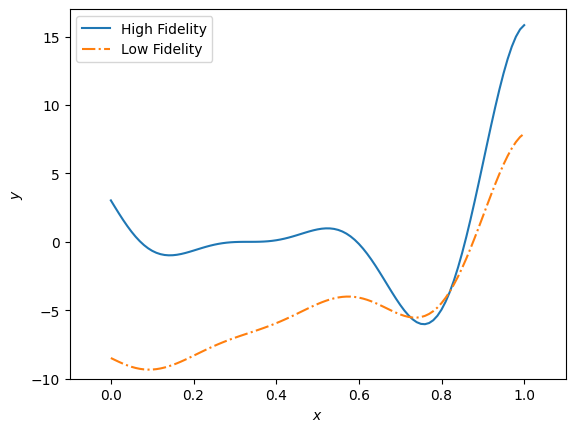

In [4]:
# Ploting High and low fidelity functions

x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)
plt.figure()

plt.plot(x, forrester_high(x), label="High Fidelity")
plt.plot(x, forrester_low(x), linestyle="-.", label="Low Fidelity")

plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

In [5]:
# Create DoE
ndim = 1
nlvl = 2
ndoe = 7  # Observations in High fidelity

n_start = 1
ndoe_lf = 2 ** (nlvl - 1) * ndoe

N_lf = np.array([10]) * ndoe_lf  # Aditional Observations in Low Fidelity

# Nested DOE
xlimits = np.array([[0.0, 1.0]])
ylimits = [-11.0, 17.0]

ntest = 100
x = np.linspace(xlimits[0][0], xlimits[0][1], ntest, endpoint=True).reshape(-1, 1)

fh = forrester_high(x)
fl = forrester_low(x)

# Selection of different inducing points.
inducing_points = [5, 8, 10]


# Initialization of variables to measure time and RMSE calculation
mfkt_time = []
smfkt_time = []
error_mfk = []
error_smfk = []
all_data = []

HF obs: 7 LF obs: 140
Prediction using 5 inducing points
Training


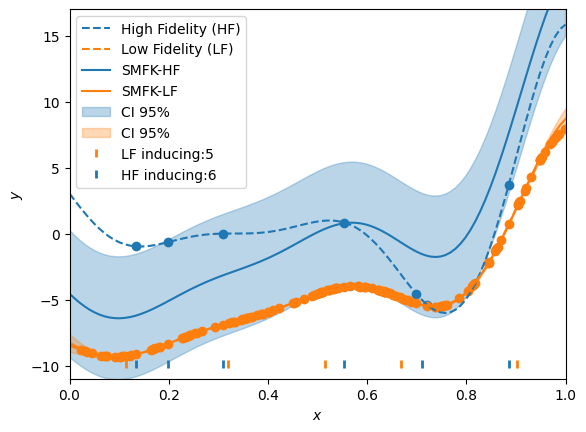

Prediction using 8 inducing points
Training


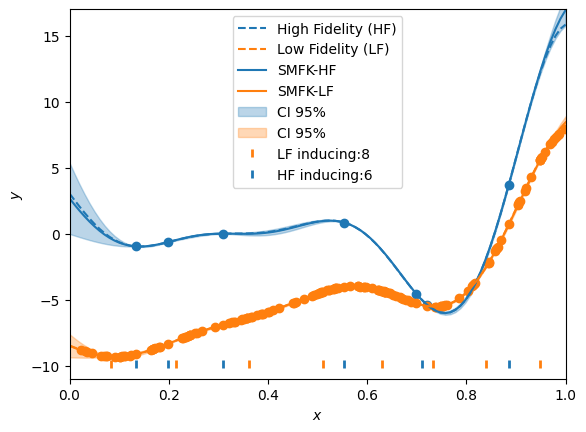

Prediction using 10 inducing points
Training


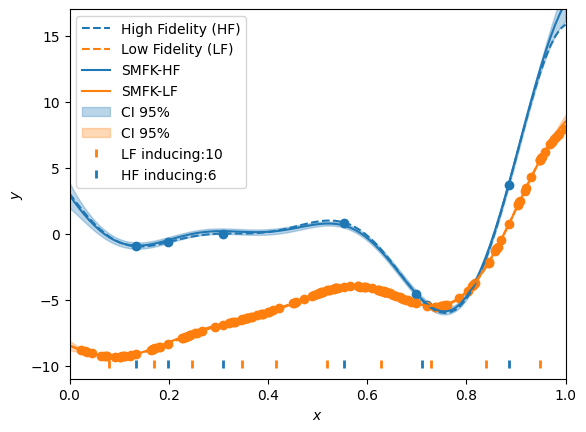

In [6]:
for N_iter in N_lf:
    print("HF obs:", ndoe, "LF obs:", N_iter)

    xdoes = NestedLHS(nlevel=nlvl, xlimits=xlimits, seed=0)
    Xt_c, Xt_e = xdoes(ndoe)
    Xt_e = np.sort(Xt_e, axis=0)
    interval = (xlimits[0][0], xlimits[0][1])
    exclude_values = Xt_c
    precision = 1e-2

    # Generate random values and filter exclusions
    new_values = []
    while len(new_values) < N_iter:
        candidates = np.random.uniform(interval[0], interval[1], N_iter * 2)
        new_values.extend(
            [v for v in candidates if np.all(np.abs(v - exclude_values) >= precision)]
        )
    new_values = np.array(new_values[:N_iter]).reshape(-1, 1)

    # Creating a LF with more observations.
    Xt_c = np.sort(Xt_c, axis=0)
    Xt_c = np.vstack((new_values, Xt_c))

    yt_e = forrester_high(Xt_e)
    yt_c = forrester_low(Xt_c)

    noise_std = 1e-3

    yt_c_noisy = yt_c + np.random.normal(0, noise_std, size=Xt_c.shape)
    yt_e_noisy = yt_e + np.random.normal(0, noise_std, size=Xt_e.shape)

    noise_bounds = np.array((1e-12, 100))

    # Test over different inducing points.
    for M in inducing_points:
        if M > N_iter:
            M = N_iter

        print("Prediction using", M, "inducing points")

        theta0 = np.array(1.2)
        theta_bounds = [1e-3, 50.0]

        smfk = SMFCK(
            hyper_opt="Cobyla-nlopt",
            method="FITC",
            theta0=[theta0],
            theta_bounds=theta_bounds,
            print_global=False,
            eval_noise=True,
            noise0=[1e-6],
            noise_bounds=noise_bounds,
            n_start=n_start,
            n_inducing=[M, ndoe - 1],
        )

        smfk.set_training_values(Xt_c, yt_c_noisy, name=0)
        smfk.set_training_values(Xt_e, yt_e_noisy)

        print("Training")
        start_training_smfk = time.time()
        smfk.train()
        smfkt_time = time.time() - start_training_smfk

        mean, cov = smfk.predict_all_levels(x)

        y = mean[-1]
        y1 = mean[0]

        var = cov[-1]
        var1 = cov[0]

        plt.figure()

        plt.plot(x, fh, "--C0", label="High Fidelity (HF)")
        plt.plot(x, fl, "--C1", label="Low Fidelity (LF)")

        plt.plot(x, y, "C0", label="SMFK-HF")

        plt.plot(x, y1, "C1", label="SMFK-LF")

        upperBound = y.flatten() + 1.96 * np.sqrt(np.abs((var.flatten())))
        lowerBound = y.flatten() - 1.96 * np.sqrt(np.abs((var.flatten())))
        plt.fill_between(
            x.flatten(),
            lowerBound.flatten(),
            upperBound.flatten(),
            label="CI 95%",
            color="C0",
            alpha=0.3,
        )

        upperBound1 = y1.flatten() + 1.96 * np.sqrt(np.abs((var1.flatten())))
        lowerBound1 = y1.flatten() - 1.96 * np.sqrt(np.abs((var1.flatten())))
        plt.fill_between(
            x.flatten(),
            lowerBound1.flatten(),
            upperBound1.flatten(),
            label="CI 95%",
            color="C1",
            alpha=0.3,
        )

        plt.plot(
            smfk.Z[0],
            -9.9 * np.ones_like(smfk.Z[0]),
            "C1|",
            mew=2,
            label=f"LF inducing:{M}",
        )

        plt.plot(
            smfk.Z[1],
            -9.9 * np.ones_like(smfk.Z[1]),
            "C0|",
            mew=2,
            label=f"HF inducing:{ndoe - 1}",
        )

        plt.scatter(Xt_e, yt_e_noisy, marker="o", color="C0")  # , label='HF doe')
        plt.scatter(Xt_c, yt_c_noisy, marker="o", color="C1")  # , label='LF doe')
        plt.legend(loc=0)
        plt.ylim(ylimits)
        plt.xlim(xlimits[0][0], xlimits[0][1])
        plt.xlabel(r"$x$")
        plt.ylabel(r"$y$")
        plt.show()

        # %%
        # ERRORS
        # SMFK

        data = {
            "Method": "SMFCK",
            "Error": np.sqrt(np.mean((fh - y) ** 2)),
            "LF observations": N_iter,
            "M": M,
            "Training time": smfkt_time,
        }

        all_data.append(data)

In [7]:
all_data

[{'Method': 'SMFCK',
  'Error': 3.8786196345545356,
  'LF observations': 140,
  'M': 5,
  'Training time': 1.6062088012695312},
 {'Method': 'SMFCK',
  'Error': 0.16624762435783424,
  'LF observations': 140,
  'M': 8,
  'Training time': 1.6630585193634033},
 {'Method': 'SMFCK',
  'Error': 0.278153826438312,
  'LF observations': 140,
  'M': 10,
  'Training time': 1.7018046379089355}]